In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
import seaborn as sns

sns.set_theme(color_codes=True)
import random
import joblib

sys.path.insert(0, ".././0.data-download/scripts/")
from data_loader import load_train_test_data, load_data
from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras

from keras.models import Model, Sequential

2023-06-20 16:28:08.340914: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# load the data
data_directory = pathlib.Path("../0.data-download/data")
train_init, test_init, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True
)

data_dir = "../0.data-download/data/"
model_df, dependency_df = load_data(data_dir, adult_or_pediatric="all")

In [4]:
# drop the string values
train_df = train_init.drop(columns=["ModelID", "age_and_sex"])
test_df = test_init.drop(columns=["ModelID", "age_and_sex"])

In [5]:
# subsetting the genes
# create dataframe containing the 1000 genes with the largest variances and their corresponding gene label and extract the gene labels
largest_var_df = gene_stats.nlargest(1000, "variance")
gene_list = largest_var_df["gene_ID"].tolist()
gene_list

# create new training and testing dataframes that contain only the corresponding genes
subset_train_df = train_df.filter(gene_list, axis=1)
subset_test_df = test_df.filter(gene_list, axis=1)

In [6]:
train_init["train_or_test"] = train_init.apply(lambda _: "train", axis=1)
test_init["train_or_test"] = test_init.apply(lambda _: "test", axis=1)

In [7]:
# load the latent dimension dataframe

latent_df = pd.read_csv("../2.train-VAE/results/latent_df.csv")

print(latent_df.shape)

latent_df.head(5)

(912, 71)


,ModelID,0,1,2,3,4,5,6,7,8,...,60,61,62,63,64,65,66,67,68,69
0,ACH-002016,-0.184865,-0.411050,0.454746,-3.106170,0.996917,2.025824,0.128741,0.789501,-0.704711,...,1.013647,0.851004,-1.099368,1.276998,-0.734296,1.353215,0.105227,-0.353100,-0.109135,0.690944
1,ACH-002459,-0.841256,0.967951,-0.234476,-0.006460,-0.236287,-0.194632,0.713052,0.689127,1.828651,...,-1.329424,0.718433,-1.646360,0.798462,-1.527801,0.471166,-0.677441,1.965686,-0.539291,-0.636756
2,ACH-002084,-0.145864,1.285988,-2.011632,0.253741,0.411326,0.675839,0.749813,2.607659,-0.410942,...,0.910241,0.403596,-0.763382,-1.357188,0.693416,-0.384113,0.220602,1.108900,0.527525,0.628123
3,ACH-000911,-0.709051,2.570947,-0.621270,0.995376,1.026386,-0.127126,0.565364,3.134944,1.123284,...,-0.770088,-1.173011,-0.366723,0.493256,0.275975,0.190239,0.300456,-1.242162,0.374398,0.804871
4,ACH-002243,0.958294,0.273933,0.090853,0.175232,-0.983740,-1.329578,0.807019,1.022001,1.206007,...,0.483063,2.533804,-0.719492,0.484156,0.349337,0.196547,0.965003,0.365002,-1.586822,1.215492


In [8]:
# create a data frame of both test and train gene dependency data sorted by top 1000 highest gene variances
concat_frames = [train_init, test_init]
train_and_test = pd.concat(concat_frames).reset_index(drop=True)
train_and_test[["AgeCategory", "Sex"]] = train_and_test.age_and_sex.str.split(
    pat="_", expand=True
)
train_and_test_subbed = train_and_test.filter(gene_list, axis=1)
metadata_holder = []
metadata_holder = pd.DataFrame(metadata_holder)
metadata = metadata_holder.assign(
    ModelID=train_and_test.ModelID.astype(str),
    AgeCategory=train_and_test.AgeCategory.astype(str),
    Sex=train_and_test.Sex.astype(str),
    train_or_test=train_and_test.train_or_test.astype(str),
)
metadata

,ModelID,AgeCategory,Sex,train_or_test
0,ACH-002016,Adult,Female,train
1,ACH-002459,Adult,Male,train
2,ACH-002084,Adult,Female,train
3,ACH-000911,Adult,Male,train
4,ACH-002243,Adult,Female,train
...,...,...,...,...
907,ACH-001619,Adult,Male,test
908,ACH-001270,Pediatric,Male,test
909,ACH-000878,Adult,Male,test
910,ACH-000563,Adult,Male,test


In [9]:
AgeCategory = metadata.pop("AgeCategory")
Sex = metadata.pop("Sex")
train_test = metadata.pop("train_or_test")

/home/ecohen/anaconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


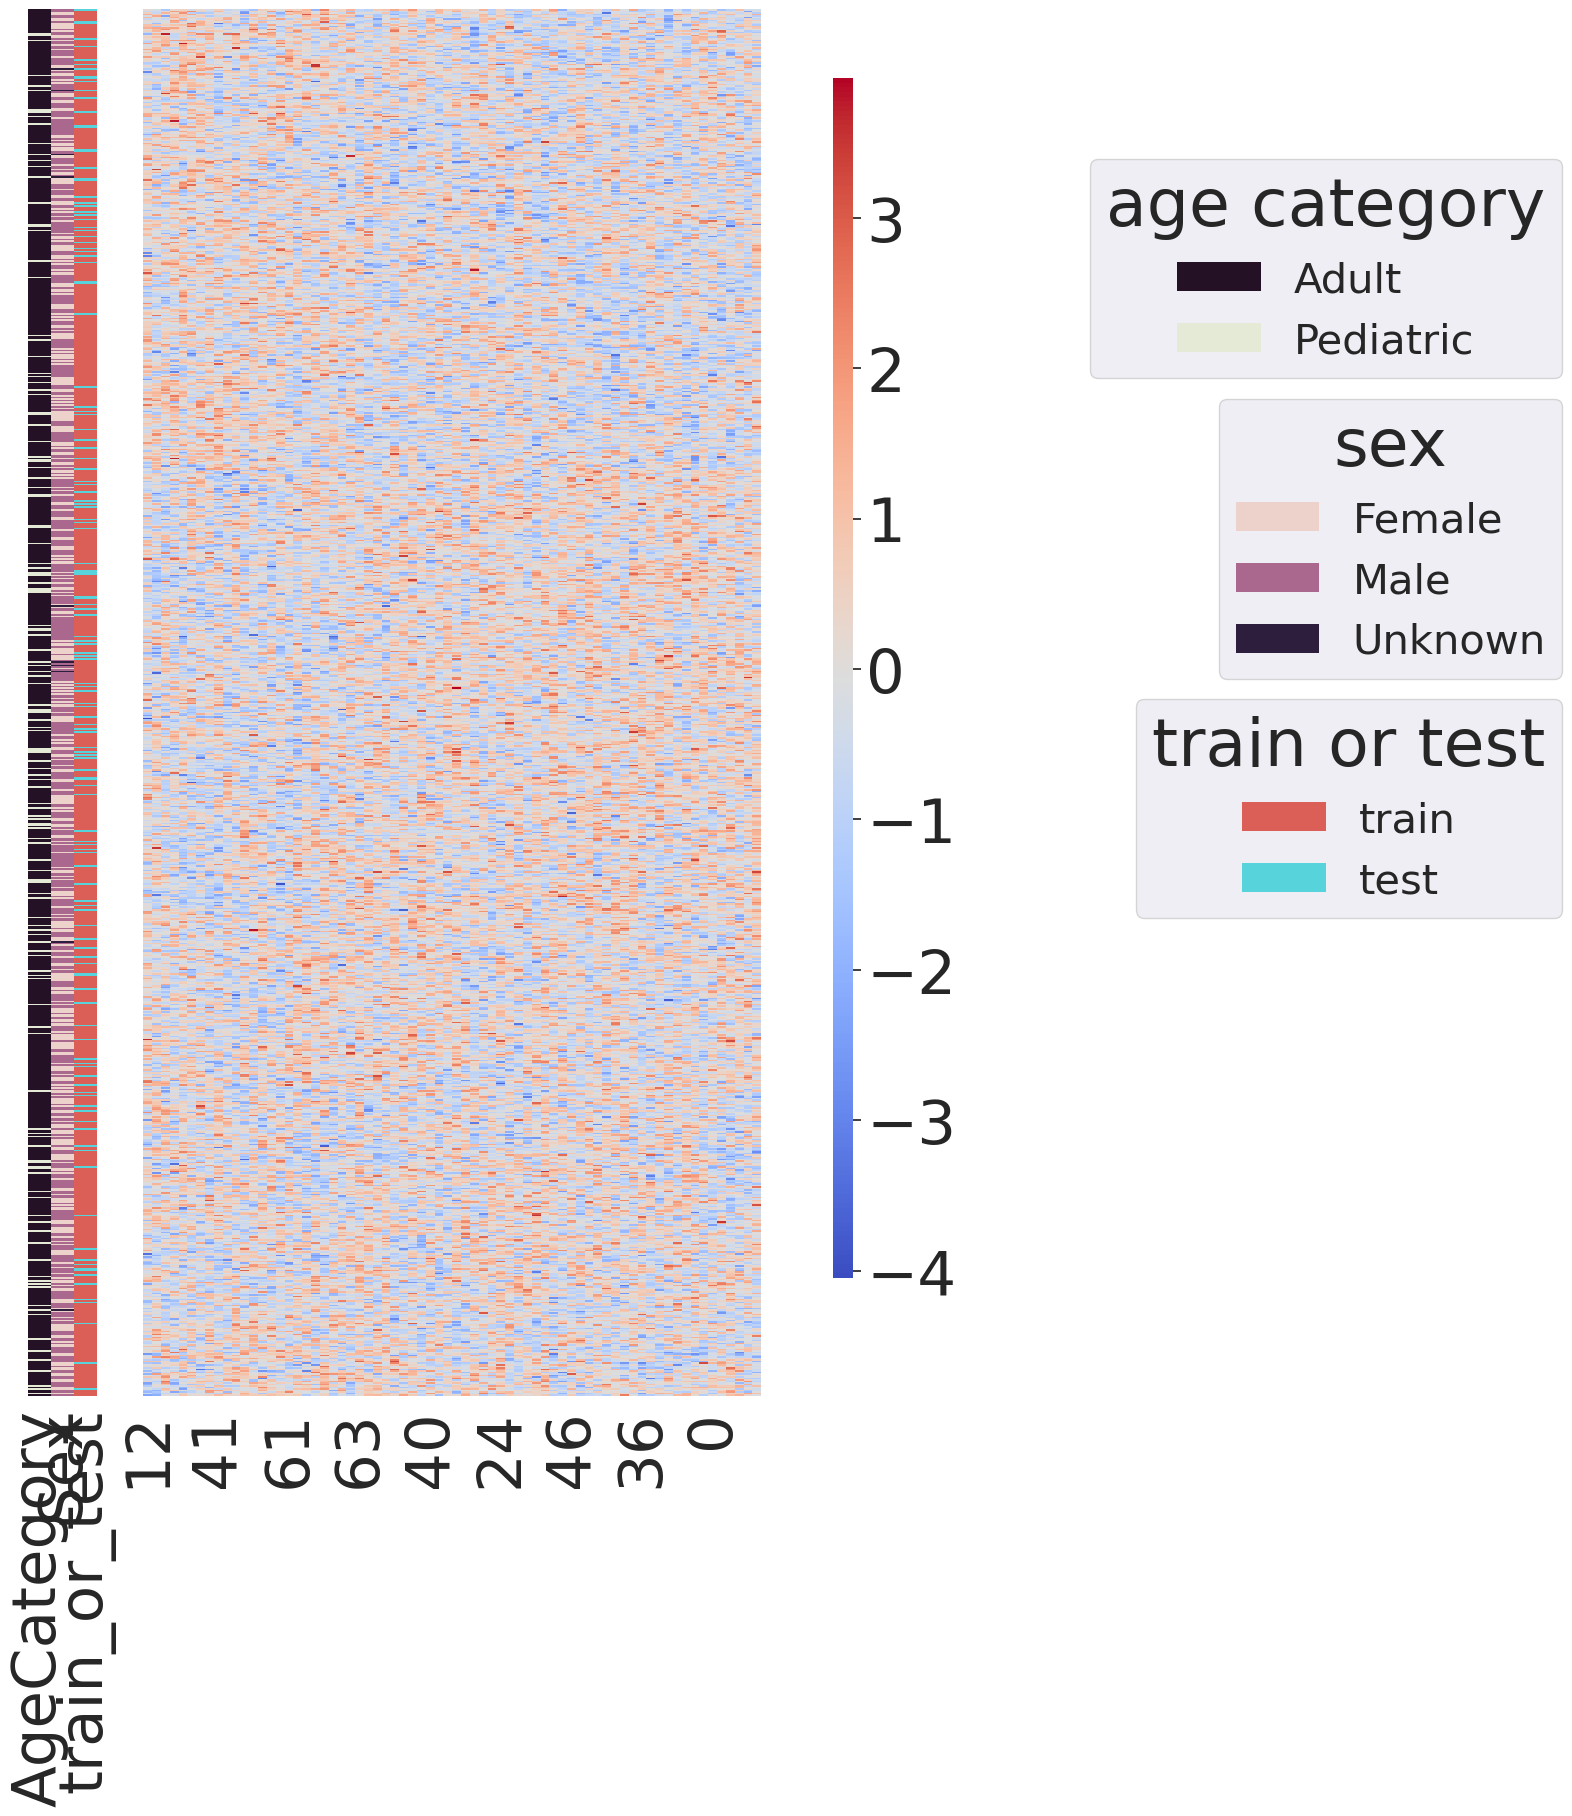

In [10]:
# display clustered heatmap of coefficients
lut_pal = sns.cubehelix_palette(
    AgeCategory.unique().size, light=0.9, dark=0.1, reverse=True, start=1, rot=-2
)
put_pal = sns.cubehelix_palette(Sex.unique().size)
mut_pal = sns.color_palette("hls", train_test.unique().size)

lut = dict(zip(AgeCategory.unique(), lut_pal))
put = dict(zip(Sex.unique(), put_pal))
mut = dict(zip(train_test.unique(), mut_pal))

row_colors1 = AgeCategory.map(lut)
row_colors2 = Sex.map(put)
row_colors3 = train_test.map(mut)

network_node_colors = pd.DataFrame(row_colors1).join(
    pd.DataFrame(row_colors2).join(pd.DataFrame(row_colors3))
)

sns.set(font_scale=4.0)
g = sns.clustermap(
    latent_df.iloc[:,1:],
    method="ward",
    figsize=(10, 20),
    row_colors=network_node_colors,
    yticklabels=False,
    dendrogram_ratio=(0.1, 0.04),
    cbar_pos=(1, 0.3, 0.02, 0.6),
    cmap = "coolwarm",
)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)


xx = []
for label in AgeCategory.unique():
    x = g.ax_row_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)
    xx.append(x)
# add the legend
legend3 = plt.legend(
    xx,
    AgeCategory.unique(),
    loc="upper right",
    title="age category",
    ncol=1,
    bbox_to_anchor=(1.75, 0.87),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)


yy = []
for label in Sex.unique():
    y = g.ax_row_dendrogram.bar(0, 0, color=put[label], label=label, linewidth=0)
    yy.append(y)
# add the second legend
legend4 = plt.legend(
    yy,
    Sex.unique(),
    loc="upper right",
    title="sex",
    ncol=1,
    bbox_to_anchor=(1.75, 0.75),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)
plt.gca().add_artist(legend3)


zz = []
for label in train_test.unique():
    z = g.ax_row_dendrogram.bar(0, 0, color=mut[label], label=label, linewidth=0)
    zz.append(z)
# add the third legend
legend5 = plt.legend(
    zz,
    train_test.unique(),
    loc="upper right",
    title="train or test",
    ncol=1,
    bbox_to_anchor=(1.75, 0.6),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)
plt.gca().add_artist(legend4)


# save the figure
heat_save_path = pathlib.Path("../1.data-exploration/figures/heatmap.png")
plt.savefig(heat_save_path, bbox_inches="tight", dpi=600)

In [11]:
# load the weights dataframe

gene_weights_df = pd.read_csv("../2.train-VAE/results/weight_matrix_encoder.csv")

gene_weights_df

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,-0.065517,-0.032733,0.016796,-0.054844,0.036953,-0.050535,0.035076,0.007159,0.032103,-0.022363,...,0.067391,-0.024657,-0.012545,0.004022,0.009111,0.007209,0.038655,0.041393,-0.013804,0.034198
1,-0.002679,0.045508,0.031917,0.006865,-0.011732,-0.044319,-0.001106,-0.030111,-0.032521,-0.060816,...,-0.003756,-0.098214,-0.030270,0.029220,0.024960,-0.031610,-0.077953,-0.005751,-0.028775,-0.027772
2,-0.065351,-0.022536,0.002443,0.003644,-0.052182,0.003413,0.043525,-0.001345,0.041294,-0.059640,...,0.052262,-0.020468,-0.038528,0.019662,0.013879,-0.020691,0.019237,0.010507,-0.010602,0.025415
3,-0.051662,-0.011450,-0.063152,0.023219,0.004973,0.056593,0.018017,-0.054374,-0.011835,-0.080668,...,0.005306,-0.060739,-0.045656,-0.001605,-0.040403,-0.023258,-0.043615,-0.081619,-0.029048,-0.069127
4,-0.013521,-0.010980,-0.004323,0.046486,-0.047013,0.034360,-0.049736,0.044843,-0.027027,0.004495,...,-0.012993,-0.016999,-0.053929,0.027880,0.047067,0.017589,-0.057068,-0.060426,-0.073335,-0.057183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.056660,0.016494,0.057415,-0.020020,0.047135,-0.024393,-0.003483,-0.006832,0.064458,0.036458,...,0.031999,-0.082593,0.093476,-0.050675,-0.031053,-0.056769,-0.074063,-0.010055,0.009805,-0.061532
996,0.072027,-0.067409,-0.044339,0.016936,-0.049171,-0.006861,0.071216,-0.060358,0.012953,-0.057297,...,0.018840,-0.079657,0.054719,0.039676,-0.021489,0.050081,0.061955,-0.001199,0.007989,-0.018846
997,-0.044053,-0.021051,-0.013642,-0.004796,0.044528,0.008457,0.024015,-0.008911,0.008913,-0.032392,...,-0.035557,0.029946,0.064144,0.031380,-0.072291,0.044656,-0.022884,0.041688,-0.036776,-0.054459
998,0.054127,0.050692,-0.040964,-0.001730,-0.053756,-0.031125,-0.019245,0.056412,0.009264,0.003794,...,0.054932,0.033690,-0.006821,0.051373,0.044199,0.050829,-0.056227,-0.069513,0.024562,0.036344


/home/ecohen/anaconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


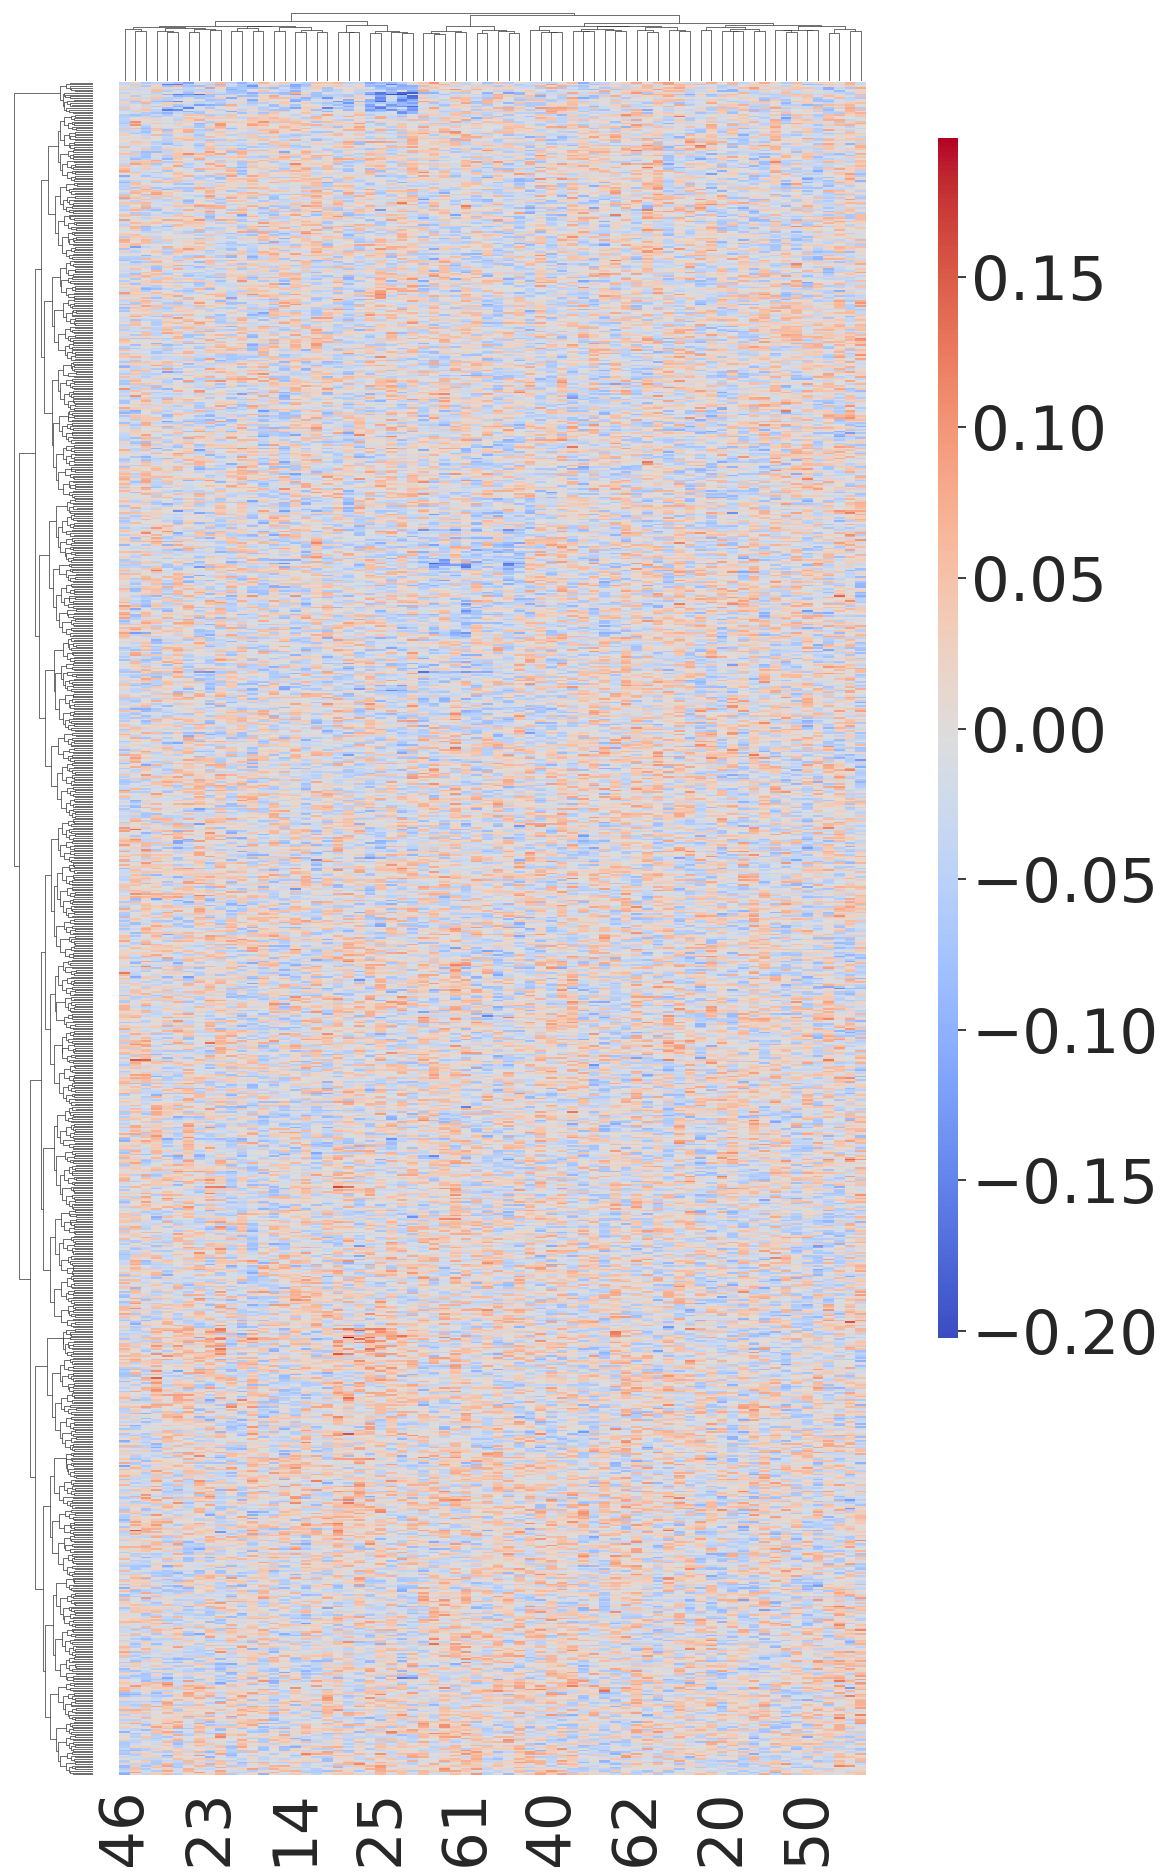

In [12]:
sns.clustermap(
    gene_weights_df,
    method="ward",
    figsize=(10, 20),
    #network_node_colors = pd.DataFrame(row_colors1).join(pd.DataFrame(row_colors2).join(pd.DataFrame(row_colors3))
    #row_colors=network_node_colors,
    yticklabels=False,
    dendrogram_ratio=(0.1, 0.04),
    cbar_pos=(1, 0.3, 0.02, 0.6),
    cmap = "coolwarm",
)
